# Working with histology images

My goal is to generate patches and save them to disk. Perhaps also compare between saving to PNG or HDF5.

See the [Aachen Protocol for deep learning histopathology](https://zenodo.org/record/3694994). Kather lab uses this.

See girder's [large_image](https://digitalslidearchive.github.io/HistomicsTK/examples/using_large_image.html) and [histomicsTK](https://digitalslidearchive.github.io/HistomicsTK/examples/using_large_image.html).

## Some important notes on coordinate systems

- Openslide `slide.dimensions` orients data as `(cols, rows, channels)`.
- PIL orients data as `(cols, rows, channels)`.
- Scikit-image orients data as `(rows, cols, channels)`.
- Matplotlib pyplot imshow expects data as `(rows, cols, channels)`.

# Use openslide to extract tiles

In the following code, we implement all of the plumbing to extract tiles from a whole slide image (WSI).

In [1]:
from pathlib import Path
from typing import List, NamedTuple, Tuple, Union

import numpy as np
import openslide
import PIL

PathType = Union[Path, str]

In [2]:
def get_num_tiles(
    slide_size: Tuple[int, int],
    tile_size: Tuple[int, int],
    strides: Tuple[int, int] = None,
) -> Tuple[int, int]:
    """Get number of tiles that can be taken from a whole slide.

    Does not include partial tiles (i.e., at edges).

    Parameters
    ----------
    slide_size : (int, int)
        Size of slide as (cols, rows).
    tile_size : (int, int)
        Size of tile as (cols, rows).
    strides : (int, int)
        Strides as (cols, rows). By default, sets strides for
        non-overlapping tiles.

    Returns
    -------
    (int, int)
        Number of tiles as (cols, rows).
    """

    def f(slide, tile, stride):
        return (slide - tile) // stride + 1

    # By default, no overlap.
    strides = strides or tile_size
    num_tiles_w = f(slide_size[0], tile_size[0], strides[0])
    num_tiles_h = f(slide_size[1], tile_size[1], strides[1])
    return num_tiles_w, num_tiles_h

In [3]:
class TileMeta(NamedTuple):
    """Metadata for one tile.

    Includes information like position and size.
    """

    oslide: openslide.OpenSlide
    wsi_id: str
    c: int  # column of the top-left
    r: int  # row of the top-left
    cols: int  # columns in the tile
    rows: int  # rows in the tile
    level: int
    tile_path: Path

    @property
    def filepath(self) -> Path:
        f = f"wsi-{self.wsi_id}_col-{self.c:07d}_row-{self.r:07d}_level-{self.level:02d}.png"
        return self.tile_path / f

    def as_pil_image(self) -> PIL.Image.Image:
        img = self.oslide.read_region(
            location=(self.c, self.r),
            level=self.level,
            size=(self.cols, self.rows),
        )
        return img

In [4]:
def get_tilemetas(
    oslide: openslide.OpenSlide,
    wsi_id: str,
    level: int,
    tile_size: Tuple[int, int],
    strides: Tuple[int, int] = None,
    tile_path: PathType = Path("tiles"),
) -> np.ndarray:
    """Return 2D array of TileMeta instances.

    These TileMeta instances include metadata
    (e.g., position, size) for each tile in the whole slide image.

    Parameters
    ----------
    oslide : openslide.OpenSlide
        The whole slide image.
    wsi_id : str
        The unique ID of this whole slide image.
    level : int
        Level of the whole slide image from which to extract tiles.
    tile_size : (int, int)
        Size of tiles as (cols, rows).
    strides : (int, int)
        Size of strides as (cols, rows). By default, uses
        strides equal to tile size, to create non-overlapping tiles.
    tile_path: Path, str
        Directory in which to save the tiles.

    Returns
    -------
    np.ndarray
        Two-dimensional array of TileMeta instances. The TileMeta
        instance of position col,row in the array corresponds to its
        position on the whole slide image.
    """

    num_tiles_w, num_tiles_h = get_num_tiles(
        slide_size=oslide.dimensions, tile_size=tile_size, strides=strides
    )
    # Get position for each tile (top-left).
    cs = list(range(0, oslide.dimensions[0], strides[0]))
    rs = list(range(0, oslide.dimensions[1], strides[1]))
    cs = cs[:num_tiles_w]
    rs = rs[:num_tiles_h]

    # sanity check that last tile does not go past slide dimensions.
    assert (cs[-1] + tile_size[0]) <= oslide.dimensions[0]
    assert (rs[-1] + tile_size[1]) <= oslide.dimensions[1]

    # Shape is in format (cols, rows).
    result = np.empty((num_tiles_w, num_tiles_h), dtype=object)
    for i, col in zip(range(num_tiles_w), cs):
        for j, row in zip(range(num_tiles_h), rs):
            result[i, j] = TileMeta(
                oslide=oslide,
                wsi_id=wsi_id,
                c=col,
                r=row,
                cols=tile_size[0],
                rows=tile_size[1],
                level=level,
                tile_path=Path(tile_path),
            )
    if any(t is None for t in result.flat):
        raise ValueError("Array not filled. This should have never happened...")

    return result

In [5]:
# todo: how do I know the correct level???
# look into large_image?
# see https://github.com/girder/large_image/blob/cbe308120ff194904654cbd05839267d1a0ba78b/large_image/tilesource/base.py#L1972-L2023

In [6]:
def save_one(tilemeta: TileMeta) -> bool:
    """Save one tile to disk as an image.

    Return True if file is saved and False if file already exists.
    """
    # sanity check... make sure we are not overwriting images
    if tilemeta.filepath.exists():
        return False
    img = tilemeta.as_pil_image()
    img.save(tilemeta.filepath)
    return True

## Test out the code above on a sample WSI

In the code below, we extract non-overlapping tiles.

In [7]:
# Whole slide image from
# https://data.kitware.com/api/v1/file/5899dd6d8d777f07219fcb23/download
# Use a variable name that would not be used elsewhere...
mynewslidexx = openslide.OpenSlide(
    "TCGA-02-0010-01Z-00-DX4.07de2e55-a8fe-40ee-9e98-bcb78050b9f7.svs"
)

In [8]:
tile_size = (400, 600)  # cols, rows
tile_path = Path("tiles")

all_tms = get_tilemetas(
    oslide=mynewslidexx,
    wsi_id="TCGA-02-0010-01Z-00-DX4.07de2e55-a8fe-40ee-9e98-bcb78050b9f7",
    level=0,
    tile_size=tile_size,
    # strides=tile_size gives non-overlapping tiles.
    strides=tile_size,
    tile_path=tile_path,
)

print(
    f"Found {all_tms.size:,} tiles in"
    f" {all_tms.shape[0]} columns and {all_tms.shape[1]} rows."
)

Found 5,120 tiles in 80 columns and 64 rows.


### Save subset of tiles to disc

In [9]:
!rm -r $tile_path
tile_path.mkdir(exist_ok=True)

In [10]:
import tqdm

results = []
subset_tms = all_tms[2:20, 30:32]
for tm in tqdm.tqdm(subset_tms.flat):
    res = save_one(tm)
    results.append(res)

100%|██████████| 36/36 [00:02<00:00, 12.53it/s]


In [11]:
!du -h $tile_path

20M	tiles


## Visualize 2x2 tiles

In [12]:
import matplotlib.pyplot as plt
import skimage.io

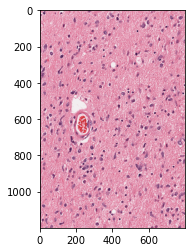

In [13]:
# Now the data are in (row, col) format for skimage.
# But subset_tms is in format (col, row). Oy...
rows, cols = 600, 400
big_img = np.zeros((rows * 2, cols * 2, 4), dtype="uint8")
big_img[:rows, :cols, :] = skimage.io.imread(subset_tms[10, 0].filepath)
big_img[:rows, cols:, :] = skimage.io.imread(subset_tms[11, 0].filepath)
big_img[rows:, :cols, :] = skimage.io.imread(subset_tms[10, 1].filepath)
big_img[rows:, cols:, :] = skimage.io.imread(subset_tms[11, 1].filepath)
plt.imshow(big_img)
skimage.io.imsave("tmp2x2.png", big_img)

## Save larger tiles

In the following code, we extract larger tiles with the idea that we can rotate them and crop the center without having artifacts. If one rotates an image, it will have empty corners. So we can take a larger image, rotate, and crop our desired tile without worrying about artifacts in corners.

The minimum size we need is the hypotenuse of the desired tile size.

In [ ]:
tile_size = (400, 600)  # cols, rows

In [ ]:
hypotenuse = np.ceil(np.hypot(*tile_size)).astype(int)
hypotenuse

In [ ]:
all_tms = get_tilemetas(
    oslide=mynewslidexx,
    wsi_id="foo",
    level=0,
    tile_size=(hypotenuse, hypotenuse),
    # TODO: what are optimal strides?
    strides=tile_size,
    tile_path="tiles",
)

print(
    f"Found {all_tms.size:,} tiles in"
    f" {all_tms.shape[0]} columns and {all_tms.shape[1]} rows."
)

In [ ]:
!rm -r $tile_path
tile_path.mkdir(exist_ok=True)

In [ ]:
import tqdm

results = []
subset_tms = all_tms[2:20, 30:32]
for tm in tqdm.tqdm(subset_tms.flat):
    res = save_one(tm)
    results.append(res)

!du -h $tile_path

## Save tiles to disc synchronously

In [ ]:
!mkdir -p tiles

In [ ]:
import tqdm

results = []
for tm in tqdm.tqdm(all_tms[12000:12100]):
    res = save_one(tm)
    results.append(res)

In [ ]:
!du -sh tiles

## Save tiles to disc asynchronously (multiple processes)

Doesn't work because of pointers in ctypes object (probably openslide object).

In [ ]:
import multiprocessing as mp

In [ ]:
with mp.Pool(processes=4) as pool:
    results = pool.map(save_one, all_tms[:100])

In [ ]:
# oh no... probably the openslide object. but we need that...

## Plot gridlines to see tiles

It would be nice to indicate on this grid which tiles are kept and which are not.
Though this is probably more work necessary...

In [ ]:
def get_grid_on_thumb(
    oslide: openslide.OpenSlide,
    tile_size: Tuple[int, int],
    strides: Tuple[int, int] = None,
    thumb_size: Tuple[int, int] = (512, 512),
) -> PIL.Image.Image:
    """Return thumbnail of slide with gridlines indicating tiles."""
    import PIL.ImageDraw

    strides = strides or tile_size
    num_tiles_w, num_tiles_h = get_num_tiles(oslide.dimensions, tile_size)
    thumb = oslide.get_thumbnail(thumb_size)
    factor_w = thumb.size[0] / oslide.dimensions[0]
    factor_h = thumb.size[1] / oslide.dimensions[1]

    max_w = (num_tiles_w) * tile_size[0] * factor_w
    max_h = (num_tiles_h) * tile_size[1] * factor_h

    draw = PIL.ImageDraw.Draw(thumb)

    # vertical lines
    for i in range(num_tiles_w + 1):
        i = i * factor_w * tile_size[0]
        draw.line((i, 0, i, max_h), fill=0, width=1)

    # horizontal lines
    for j in range(num_tiles_h + 1):
        j = j * factor_h * tile_size[1]
        draw.line((0, j, max_w, j), fill=0, width=1)

    return thumb

In [ ]:
get_grid_on_thumb(mynewslidexx, tile_size=(hypotenuse, hypotenuse))

# Data input pipeline using TensorFlow

But use scikit-image for image processing (rotations, changing brightness, etc.).

**Data are formatted as rows, cols.**. Not x, y. So shape is height, width.

This code relies on files made using the preceding code.

Idea... to extract slightly larger patches (to allow for rotation), randomly rotate, and crop randomly inside a central bbox?

In [ ]:
import math

import matplotlib.pyplot as plt
import skimage.io
import skimage.transform
import tensorflow as tf

In [ ]:
img = skimage.io.imread("tiles/wsi-foo_col-0000800_row-0018000_level-00.png")
img = img[..., :3]  # remove alpha channel
skimage.io.imshow(img)

In [ ]:
import numpy

In [ ]:
prng = numpy.random.default_rng(seed=42)

In [ ]:
angle = prng.uniform(0, 360)
skimage.io.imshow(skimage.transform.rotate(img, angle, order=3))

In [ ]:
import skimage.util
import numpy as np

In [ ]:
def rotatedRectWithMaxArea(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle (maximal area) within the rotated rectangle.

    See https://stackoverflow.com/a/16778797/5666087.
    """
    import math

    if w <= 0 or h <= 0:
        return 0, 0

    width_is_longer = w >= h
    side_long, side_short = (w, h) if width_is_longer else (h, w)

    # since the solutions for angle, -angle and 180-angle are all the same,
    # if suffices to look at the first quadrant and the absolute values of sin,cos:
    sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
    if side_short <= 2.0 * sin_a * cos_a * side_long or abs(sin_a - cos_a) < 1e-10:
        # half constrained case: two crop corners touch the longer side,
        #   the other two corners are on the mid-line parallel to the longer line
        x = 0.5 * side_short
        wr, hr = (x / sin_a, x / cos_a) if width_is_longer else (x / cos_a, x / sin_a)
    else:
        # fully constrained case: crop touches all 4 sides
        cos_2a = cos_a * cos_a - sin_a * sin_a
        wr, hr = (w * cos_a - h * sin_a) / cos_2a, (h * cos_a - w * sin_a) / cos_2a

    return wr, hr

In [ ]:
angle = 20
img_rot = skimage.transform.rotate(img, angle, order=3)

In [ ]:
max_w, max_h = rotatedRectWithMaxArea(hypotenuse, hypotenuse, np.deg2rad(angle))
max_w, max_h = int(max_w), int(max_h)

In [ ]:
(img_rot.shape[0] - max_w) // 2

In [ ]:
img_rot_cropped = img_rot[42 : 42 + max_w, 42 : 42 + max_h]

In [ ]:
image_shape = (298, 298)
crop_size = (200, 200)
limit = np.array(image_shape) - crop_size + 1
starts = [
    int(prng.uniform(low=0.0, high=limit[0])),
    int(prng.uniform(low=0.0, high=limit[1])),
]

img_rot_cropped2 = img_rot_cropped[
    starts[0] : starts[0] + crop_size[0], starts[1] : starts[1] + crop_size[1]
]

fig, axes = plt.subplots(1, 3, figsize=(12, 8))
axes[0].imshow(img_rot)
axes[1].imshow(img_rot_cropped)
axes[2].imshow(img_rot_cropped2)
axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")
plt.tight_layout()

In [ ]:
img_rot_cropped

In [ ]:
image_shape = (298, 298)
crop_size = (270, 270)
# np.array(image_shape) - crop_size + 1
start = int(prng.uniform(low=0.0, high=29))

img_rot_cropped2 = img_rot_cropped[
    start : start + crop_size[0], start : start + crop_size[1]
]

skimage.io.imshow(img_rot_cropped2)

In [ ]:
    offset = random_uniform(
        array_ops.shape(shape),
        dtype=size.dtype,
        maxval=size.dtype.max,
        seed=seed) % limit

In [ ]:
img_win = skimage.util.view_as_windows(img_rot, (270, 270, 3), step=1)[:, :, 0, :, :, :]

In [ ]:
skimage.io.imshow(img_win[56, 57])

In [ ]:
img_win = skimage.util.view_as_windows(img, (270, 270, 3), step=1)[:, :, 0, :, :, :]

In [ ]:
img_win.shape

In [ ]:
skimage.io.imshow(img_win[0, 0])

In [ ]:
skimage.io.imshow(img_win[0, 1])

In [ ]:
contents = tf.io.read_file("tiles/wsi-foo_posi-0003072_posj-0009216_level-00.png")
img = tf.image.decode_png(contents, channels=3)
img = tf.reshape(img, (512, 512, 3))
plt.imshow(img)

In [ ]:
plt.imshow(tf.image.rgb_to_grayscale(img), cmap="gray")

In [ ]:
plt.imshow(tf.image.adjust_contrast(img, 0.5))
plt.show()
plt.imshow(tf.image.adjust_contrast(img, 2))
plt.show()

In [ ]:
plt.imshow(tf.image.adjust_saturation(img, 2))
plt.show()

In [ ]:
plt.imshow(tf.image.adjust_jpeg_quality(img, 75))

In [ ]:
plt.imshow(tf.image.random_crop(img, (256, 256, 3)))

In [ ]:
import math

In [ ]:
def _get_transform_for_angle(angles, image_height, image_width):
    cos_angles = tf.math.cos(angles)
    sin_angles = tf.math.sin(angles)
    x_offset = (
        (image_width - 1)
        - (cos_angles * (image_width - 1) - sin_angles * (image_height - 1))
    ) / 2.0
    y_offset = (
        (image_height - 1)
        - (sin_angles * (image_width - 1) + cos_angles * (image_height - 1))
    ) / 2.0
    num_angles = tf.shape(angles)[0]
    return tf.concat(
        values=[
            cos_angles[:, None],
            -sin_angles[:, None],
            x_offset[:, None],
            sin_angles[:, None],
            cos_angles[:, None],
            y_offset[:, None],
            tf.zeros((num_angles, 2), tf.dtypes.float32),
        ],
        axis=1,
    )

In [ ]:
transform

In [ ]:
import random

angle = random.uniform(0, 2 * math.pi)

transform = _get_transform_for_angle([angle], 512, 512)

# be extremely careful with this method... it will not raise an exception on
# some invalid parameters, like a lowercase interpolation value...
img2 = tf.raw_ops.ImageProjectiveTransformV2(
    images=img[None],
    transforms=transform,
    output_shape=(512, 512),
    interpolation="BILINEAR",
)
img2 = img2[0]

plt.imshow(img2)

In [ ]:
>0.86 (220/255)

In [ ]:
tf.cast(img, "float32") > (200 / 255)

In [ ]:
# How to get brightness of tiles?? Kather et al. 2020 removes tiles with
# overall brightness > (200/255).

In [ ]:
mask = tf.reduce_sum(tf.cast(img, "float32") * [0.3, 0.59, 0.11], axis=-1) > (200 / 255)